In [4]:
import glob
import numpy as np
import pickle
from scipy import ndimage as ndimage
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import image
import os
import random
import matplotlib.animation as animation
import collections

In [5]:
def resize_gestures(input_gestures, final_length=100):

    output_gestures = np.array([np.array([ndimage.zoom(x_i.T[j], final_length / len(x_i), mode='reflect') for j in range(np.size(x_i, 1))]).T for x_i in input_gestures])
    return output_gestures

In [6]:
def load_gestures(root, resize_gesture_to_length=100):
   
  
    pattern = root + '/DHG/DHG2016/gesture_*/finger_*/subject_*/essai_*/skeleton_image.txt'

    gestures_filenames = sorted(glob.glob(pattern))
   
    gestures = [np.genfromtxt(f) for f in gestures_filenames]
    if resize_gesture_to_length is not None:
        gestures = resize_gestures(gestures, final_length=resize_gesture_to_length)

    labels_14 = [int(filename.split('/')[-5].split('_')[1]) for filename in gestures_filenames]

    return gestures, labels_14, gestures_filenames

In [7]:
gestures, labels_14, gestures_filenames = load_gestures(root=os.path.abspath(os.getcwd()),
                                     resize_gesture_to_length=100)

In [8]:
gestures = np.array(gestures)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(gestures,labels_14, test_size=0.3 )

In [10]:
X_test.shape

(840, 100, 44)

In [11]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
max(y_train)

14

In [13]:
from tensorflow.keras.utils import to_categorical

2022-09-22 02:47:03.459199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 02:47:03.459232: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
y_train = to_categorical(y_train, 15)

In [15]:
y_test = to_categorical(y_test, 15)

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dense,Flatten, TimeDistributed,Dropout
import keras.layers

In [17]:
import keras.backend as K

In [18]:
img_size = X_train[0].shape
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0],1, 100, 44)
    X_test = X_test.reshape(X_test.shape[0],1, 100, 44)
else:
    X_train = X_train.reshape(X_train.shape[0], 100, 44, 1)
    X_test = X_test.reshape(X_test.shape[0], 100, 44, 1)

In [19]:
input_shape1 = X_train.shape[1:]
input_shape1

(100, 44, 1)

In [20]:
import tensorflow as tf

In [21]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), strides = (1,1), padding='same', activation = 'relu',input_shape = input_shape1))
model.add(Conv2D(8, kernel_size=(3,3), strides = (1,1), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, kernel_size=(3,3), strides = (1,1), padding='same', activation = 'relu'))
model.add(Conv2D(16, kernel_size=(3,3), strides = (1,1), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), strides = (1,1), padding='same', activation = 'relu'))
model.add(Conv2D(32, kernel_size=(3,3), strides = (1,1), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))
model.add(TimeDistributed(Flatten()))

model.add(tf.keras.layers.LSTM(units =  128 ,activation = 'relu'))



model.add(Dense(units= 128, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(units= 128, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(units= 15, activation = 'softmax'))



model.summary()



2022-09-22 02:47:05.752952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-22 02:47:05.752995: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 02:47:05.753032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-09-22 02:47:05.753397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 44, 8)        80        
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 44, 8)        584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 22, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 22, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 22, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 11, 16)       0         
 2D)                                                    

In [22]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, batch_size= 64,epochs=100, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 12s 347ms/step - loss: 3.5872 - accuracy: 0.0606 - val_loss: 2.6807 - val_accuracy: 0.0842
Epoch 2/100
25/25 [==============================] - 10s 396ms/step - loss: 2.6535 - accuracy: 0.1020 - val_loss: 2.6063 - val_accuracy: 0.1327
Epoch 3/100
25/25 [==============================] - 8s 313ms/step - loss: 2.5852 - accuracy: 0.1276 - val_loss: 2.4722 - val_accuracy: 0.1582
Epoch 4/100
25/25 [==============================] - 8s 306ms/step - loss: 2.4817 - accuracy: 0.1569 - val_loss: 2.4402 - val_accuracy: 0.2219
Epoch 5/100
25/25 [==============================] - 8s 321ms/step - loss: 2.3680 - accuracy: 0.2085 - val_loss: 2.1485 - val_accuracy: 0.2959
Epoch 6/100
25/25 [==============================] - 8s 310ms/step - loss: 2.1866 - accuracy: 0.2570 - val_loss: 1.9047 - val_accuracy: 0.3724
Epoch 7/100
25/25 [==============================] - 8s 309ms/step - loss: 2.0788 - accuracy: 0.2844 - val_loss: 1.8230 - val_accuracy: 0.40

Epoch 58/100
25/25 [==============================] - 12s 475ms/step - loss: 0.3496 - accuracy: 0.8731 - val_loss: 0.8168 - val_accuracy: 0.7985
Epoch 59/100
25/25 [==============================] - 12s 499ms/step - loss: 0.3056 - accuracy: 0.8941 - val_loss: 0.7995 - val_accuracy: 0.8138
Epoch 60/100
25/25 [==============================] - 12s 501ms/step - loss: 0.3546 - accuracy: 0.8750 - val_loss: 0.8350 - val_accuracy: 0.7781
Epoch 61/100
25/25 [==============================] - 12s 481ms/step - loss: 0.3217 - accuracy: 0.8897 - val_loss: 0.8039 - val_accuracy: 0.7781
Epoch 62/100
25/25 [==============================] - 12s 481ms/step - loss: 0.2727 - accuracy: 0.9062 - val_loss: 1.1405 - val_accuracy: 0.7474
Epoch 63/100
25/25 [==============================] - 15s 622ms/step - loss: 0.4284 - accuracy: 0.8559 - val_loss: 0.8028 - val_accuracy: 0.7806
Epoch 64/100
25/25 [==============================] - 14s 568ms/step - loss: 0.3260 - accuracy: 0.8973 - val_loss: 0.9230 - val_ac

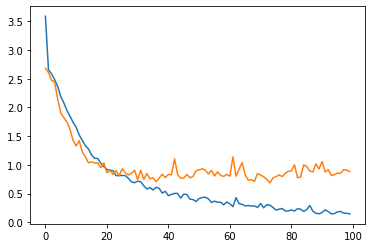

In [24]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

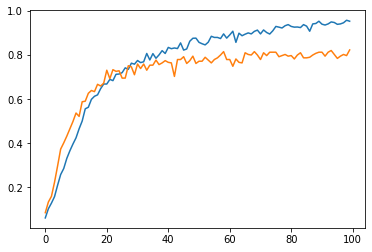

In [25]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])

In [26]:
model.evaluate(X_test, y_test)

27/27 [==============================] - 1s 37ms/step - loss: 0.9789 - accuracy: 0.7667


[0.9789353013038635, 0.7666666507720947]

In [27]:
from sklearn.metrics import confusion_matrix,classification_report

In [28]:
y_true = np.argmax(y_test, axis = 1)
y_pred = np.argmax(model.predict(X_test), axis = 1)

confusion_matrix(y_true, y_pred)

27/27 [==============================] - 1s 37ms/step


array([[33,  7,  0, 10,  0,  1,  0,  1,  1,  1,  0,  0,  0,  1],
       [ 5, 41,  1,  2,  0,  0,  0,  0,  1,  8,  0,  0,  0,  3],
       [ 0,  1, 40,  0,  1,  1,  0,  0,  7,  0,  0,  0,  0,  0],
       [21,  2,  0, 37,  0,  2,  0,  0,  3,  2,  0,  0,  0,  0],
       [ 4,  4,  1,  2, 41,  0,  3,  1,  0,  1,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  0, 53,  0,  1,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  3,  0,  0,  0, 48,  1,  3,  0,  0,  3,  7,  0],
       [ 0,  0,  0,  1,  1,  0,  1, 37,  1,  9,  1,  2,  0,  0],
       [ 0,  0,  4,  0,  1,  1,  3,  0, 46,  0,  0,  3,  1,  2],
       [ 5,  7,  0,  0,  0,  2,  0,  5,  0, 50,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  2,  0,  0, 50,  1,  6,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0, 61,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  3,  0,  0,  0, 57,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  0,  1,  0,  0,  0,  0, 50]])

In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.60      0.53        55
           2       0.65      0.67      0.66        61
           3       0.82      0.80      0.81        50
           4       0.70      0.55      0.62        67
           5       0.91      0.71      0.80        58
           6       0.88      0.95      0.91        56
           7       0.80      0.73      0.76        66
           8       0.77      0.70      0.73        53
           9       0.68      0.75      0.71        61
          10       0.69      0.70      0.70        71
          11       0.98      0.82      0.89        61
          12       0.85      0.94      0.89        65
          13       0.78      0.90      0.84        63
          14       0.88      0.94      0.91        53

    accuracy                           0.77       840
   macro avg       0.78      0.77      0.77       840
weighted avg       0.77      0.77      0.77       840



# Misclassified instances analysis

In [30]:
classes = ['Grab', 'Tap', 'Expand', 'Pinch', 'Rotation CW', 'Rotation CCW', 'Swipe Right', 'Swipe Left', 'Swipe Up',
          'Swipe Down', 'Swipe X', 'Swipe V', 'Swipe +', 'Shake']

In [31]:
img_size = gestures[0].shape
if K.image_data_format() == 'channels_first':
    gesutres = gestures.reshape(gestures.shape[0],1, 100, 44)
else:
    gestures = gestures.reshape(gestures.shape[0], 100, 44, 1)
    

y_true = np.array(labels_14)
y_pred = np.argmax(model.predict(gestures), axis = 1)

 2/88 [..............................] - ETA: 4s

2022-09-22 03:03:12.759000: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 49280000 exceeds 10% of free system memory.


88/88 [==============================] - 4s 47ms/step


In [32]:
errors = []
for i in range(gestures.shape[0]):
    true_class = y_true[i]
    pred_class = y_pred[i]
    if true_class != pred_class:
        errors.append(i)

In [33]:
def load_images_from_folder(folder):
    images = []
    mapa = {}
    for fileName in os.listdir(folder):
        if "depth" in fileName:
            niz = fileName.split('_')
            broj = niz[1].split('.')[0]
                        
            img = image.imread(os.path.join(folder,fileName))
            if img is not None:
                mapa[int(broj)] = img
               
    return mapa

In [38]:
randGest = random.choice(errors)

# dir path to specific gesture from errors 
# exmpl ../DHG/DHG2016/gesture_1/finger_2/subject_14/essai_5
gestPath = gestures_filenames[randGest]
lastDash = gestPath.rfind('/')
trueGesturePath = gestPath[:lastDash]


images = load_images_from_folder(trueGesturePath)
images = collections.OrderedDict(sorted(images.items()))

listImages = []
for key, value in images.items():
    listImages.append(value)

...........

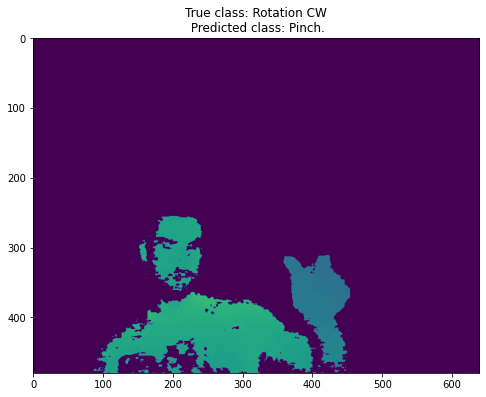

In [39]:
fps = 30
fig = plt.figure( figsize=(8,8) )

a = listImages[0]
im = plt.imshow(a)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )
    
    im.set_array(listImages[i-1])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(listImages),
                               interval = 1000 / fps, # in ms
                               )

true = classes[y_true[randGest]-1]
predicted = classes[y_pred[randGest] -1]
naslov = "True class: {}\n Predicted class: {}.".format(true, predicted)
plt.title(naslov)
from IPython.display import HTML
HTML(anim.to_jshtml())
#writergif = animation.PillowWriter(fps=30) 
#anim.save('TrueExpand_PredTap.gif', writer=writergif)